https://www.tensorflow.org/tutorials/generative/style_transfer

In [4]:
!pip install tensorflow

In [5]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 11.5MB/s 


In [6]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

     |████████████████████████████████| 50.4MB 76kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import os
import PIL
import PIL.Image

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

2.4.1


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# defining global variable path
# Location of my dataset on My Google Drive
image_path = "/content/drive/MyDrive/VM/monet_gogn/jpg"

#Skilgreinum fall sem les inn *.jpg myndirnar sem eru geymdar í ofangreindu path-i
def loadImages_monet(path):
    image_files = sorted([os.path.join(path, 'monet_jpg', file)
                          for file in os.listdir(path + "/monet_jpg")
                          if file.endswith('.jpg')])
    return image_files

def loadImages_photo(path):
    image_files = sorted([os.path.join(path, 'photo_jpg', file)
                          for file in os.listdir(path + "/photo_jpg")
                          if file.endswith('.jpg')])
    return image_files

In [13]:
#Geymum myndirnar í lista
monet_jpg = loadImages_monet(image_path)
photo_jpg = loadImages_photo(image_path)

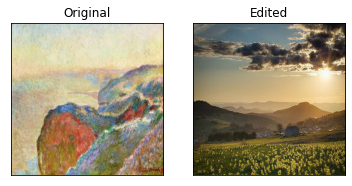

In [14]:
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

#Birtum myndir
from PIL import Image
im1 = Image.open(monet_jpg[0])
im2 = Image.open(photo_jpg[0])

display(im1, im2)

# Neural style transfer

In [15]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [16]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [17]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [18]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [19]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [20]:
#Geymum myndirnar í lista
monet_jpg = loadImages_monet(image_path)
photo_jpg = loadImages_photo(image_path)

In [23]:
from google.colab import files
img_upload=files.upload()
img_upload=files.upload()
uploaded_path = '/content/monalisa.jpg'
#uploaded_path = photo_jpg[0]
uploaded_path2 = '/content/Valgerdur.jpg'
#ny_mynd=loadImages_photo(uploaded_path)
#uploaded_path2 = monet_jpg[0]
content_image = load_img(uploaded_path )
style_image = load_img(uploaded_path2)

Saving monalisa.jpg to monalisa.jpg


Saving Valgerdur.jpg to Valgerdur.jpg


In [24]:
photo_jpg[0]

'/content/drive/MyDrive/VM/monet_gogn/jpg/photo_jpg/00068bc07f.jpg'

In [25]:
content_image

<tf.Tensor: shape=(1, 512, 343, 3), dtype=float32, numpy=
array([[[[0.4225622 , 0.48213416, 0.378435  ],
         [0.36001998, 0.38259473, 0.29602906],
         [0.30016506, 0.3510883 , 0.25576472],
         ...,
         [0.28266904, 0.33975685, 0.24448065],
         [0.28269002, 0.29565266, 0.24330276],
         [0.36569867, 0.33914283, 0.333845  ]],

        [[0.3437876 , 0.40065607, 0.32072404],
         [0.445321  , 0.47423226, 0.410757  ],
         [0.38337407, 0.42844352, 0.35887852],
         ...,
         [0.23657724, 0.28840014, 0.16206743],
         [0.23863001, 0.27433267, 0.1739787 ],
         [0.19706813, 0.21627367, 0.14251119]],

        [[0.44521868, 0.5167959 , 0.40691411],
         [0.31705093, 0.36568943, 0.26976418],
         [0.3072528 , 0.37538493, 0.2694617 ],
         ...,
         [0.3042488 , 0.39357355, 0.2616108 ],
         [0.33603606, 0.3892387 , 0.28172475],
         [0.35534298, 0.36883745, 0.295383  ]],

        ...,

        [[0.37716678, 0.33990616, 

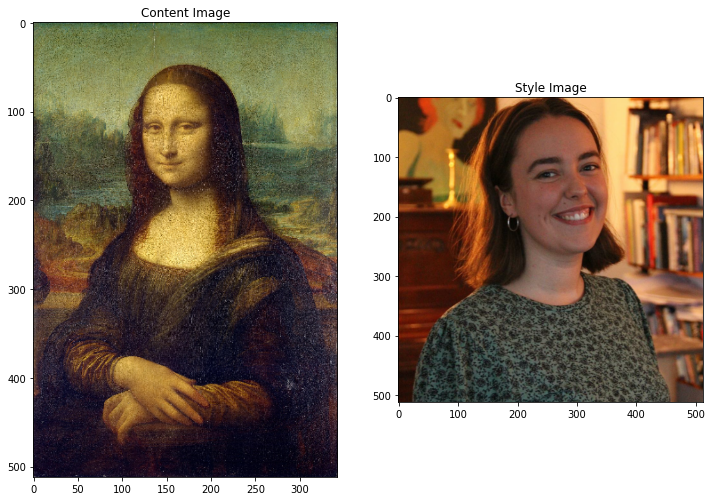

In [26]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

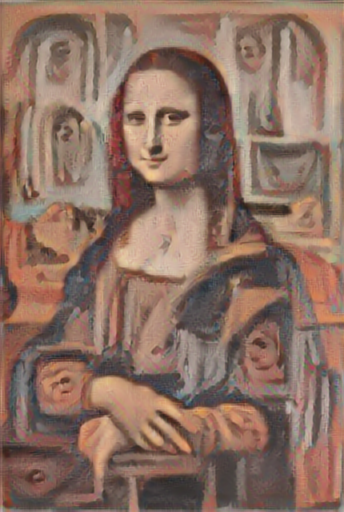

In [27]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [28]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 5s 0us/step


TensorShape([1, 1000])

In [29]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('book_jacket', 0.5614945),
 ('fur_coat', 0.16351536),
 ('maillot', 0.02113626),
 ('hoopskirt', 0.01939769),
 ('miniskirt', 0.018022748)]

In [30]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [31]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [32]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [33]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  712.6951
  mean:  24.511396

block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  3419.8074
  mean:  115.497086

block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  8528.138
  mean:  112.65497

block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  13221.883
  mean:  416.7044

block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  2347.0386
  mean:  35.05882



In [34]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [35]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [36]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0006328541
    max:  24152.941
    mean:  432.4496

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  97377.89
    mean:  12155.695

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  216248.38
    mean:  9564.592

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4613311.0
    mean:  212681.95

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  52234.957
    mean:  1151.3765

Contents:
   block5_conv2
    shape:  (1, 32, 21, 512)
    min:  0.0
    max:  1194.9067
    mean:  12.300601


In [37]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [38]:
image = tf.Variable(content_image)

In [39]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [40]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [41]:
style_weight=1e-2
content_weight=1e4

In [42]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [43]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

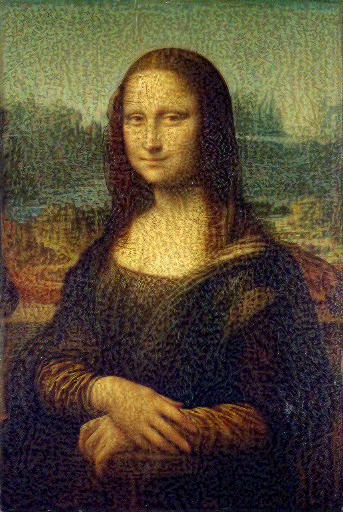

In [44]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

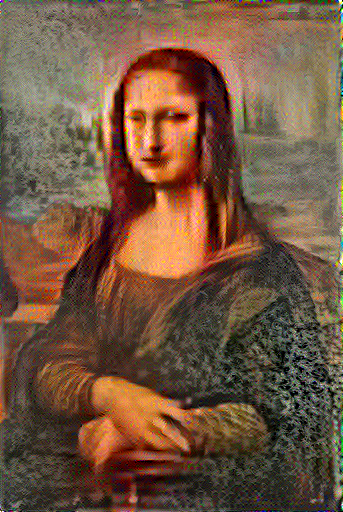

Train step: 1000
Total time: 5135.7


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Total variation loss

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

In [ ]:
tf.image.total_variation(image).numpy()

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
image = tf.Variable(content_image)

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))